In [ ]:
from IPython import get_ipython
from IPython.display import display


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print(" Still using CPU!")

CUDA available: True
GPU: Tesla T4


In [ ]:
!pip install datasets

In [ ]:
!pip install --upgrade transformers


In [ ]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import re
import torch
import os

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'&[a-zA-Z]+;', '', text)
    return text


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('drugsComTest_updated.csv')


df_reduced = df.sample(frac=0.2, random_state=42)

df_reduced = df_reduced[['drugName', 'review', 'rating']]


df_reduced['label'] = df_reduced['rating'].apply(lambda x: 1 if x >= 4 else 0)


df_reduced['review'] = df_reduced['review'].astype(str).apply(lambda x: x[:400])


df_reduced['input_text'] = (
    '[DRUG] ' + df_reduced['drugName'] + ' [REVIEW] ' +
    df_reduced['review']
)



Saving drugsComTest_updated.csv to drugsComTest_updated.csv


In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(df_reduced[['input_text', 'label']])

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['input_text'], padding="max_length", truncation=True, max_length=512)


In [ ]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10694 [00:00<?, ? examples/s]

In [ ]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)

In [ ]:
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,

    eval_strategy='epoch',
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
import transformers
import datasets
import torch

print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Torch:", torch.__version__)


Transformers: 4.57.1
Datasets: 4.0.0
Torch: 2.8.0+cu126


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
import time
start = time.time()

In [ ]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: varshanistala (varshanistala-ibm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.276100,0.434647,0.833100
2,0.410000,0.441625,0.853670
3,0.075400,0.582962,0.853202


TrainOutput(global_step=3210, training_loss=0.30846621824944875, metrics={'train_runtime': 1284.761, 'train_samples_per_second': 19.976, 'train_steps_per_second': 2.499, 'total_flos': 3399775786506240.0, 'train_loss': 0.30846621824944875, 'epoch': 3.0})

In [ ]:
end = time.time()
print(f"Training time: {(end - start)/60:.2f} minutes")

Training time: 21.42 minutes


In [ ]:
results = trainer.evaluate()
print(f"Evaluation results: {results}")

Evaluation results: {'eval_loss': 0.43464696407318115, 'eval_accuracy': 0.8330995792426368, 'eval_runtime': 29.6123, 'eval_samples_per_second': 72.233, 'eval_steps_per_second': 9.05, 'epoch': 3.0}


In [ ]:
def predict_sentiment(review_text, drug_name):

    combined_text = f"[DRUG] {drug_name} [REVIEW] {preprocess_text(review_text)}"

    inputs = tokenizer(combined_text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()

    return "Good" if predicted_class == 1 else "Bad"


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


y_test = test_dataset['label']


predictions = trainer.predict(test_dataset)
pred_df = predictions.predictions.argmax(axis=-1)

print(metrics.accuracy_score(y_test, pred_df))

print(metrics.confusion_matrix(y_test, pred_df))

print(metrics.classification_report(y_test, pred_df))

0.8330995792426368
[[ 141  326]
 [  31 1641]]
              precision    recall  f1-score   support

           0       0.82      0.30      0.44       467
           1       0.83      0.98      0.90      1672

    accuracy                           0.83      2139
   macro avg       0.83      0.64      0.67      2139
weighted avg       0.83      0.83      0.80      2139



In [ ]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, roc_auc_score, log_loss, cohen_kappa_score, matthews_corrcoef
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


logits = predictions.predictions
y_true = test_dataset['label']
y_pred = np.argmax(logits, axis=1)

probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)


print(" Accuracy:", accuracy_score(y_true, y_pred))
print(" Macro F1 Score:", f1_score(y_true, y_pred, average='macro'))
print(" Classification Report:\n", classification_report(y_true, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


print(" Log Loss:", log_loss(y_true, probs))
print(" Cohen's Kappa:", cohen_kappa_score(y_true, y_pred))
print(" Matthews Corr Coef:", matthews_corrcoef(y_true, y_pred))


if probs.shape[1] == 2:
    y_probs = probs[:, 1]
    print(" ROC AUC (binary):", roc_auc_score(y_true, y_probs))
else:
    auc_score = roc_auc_score(y_true, probs, multi_class='ovr', average='macro')
    print(" ROC AUC (macro):", auc_score)



 Accuracy: 0.8330995792426368
 Macro F1 Score: 0.6716053396498806
 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.30      0.44       467
           1       0.83      0.98      0.90      1672

    accuracy                           0.83      2139
   macro avg       0.83      0.64      0.67      2139
weighted avg       0.83      0.83      0.80      2139

 Confusion Matrix:
 [[ 141  326]
 [  31 1641]]
 Log Loss: 0.434646952518537
 Cohen's Kappa: 0.3669042500536821
 Matthews Corr Coef: 0.43051607202451325
 ROC AUC (binary): 0.8702614161449955


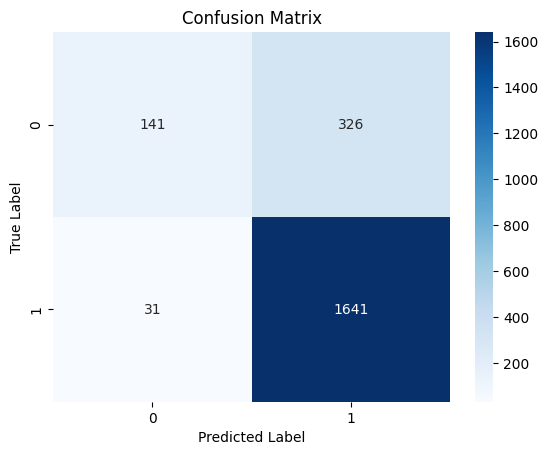

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


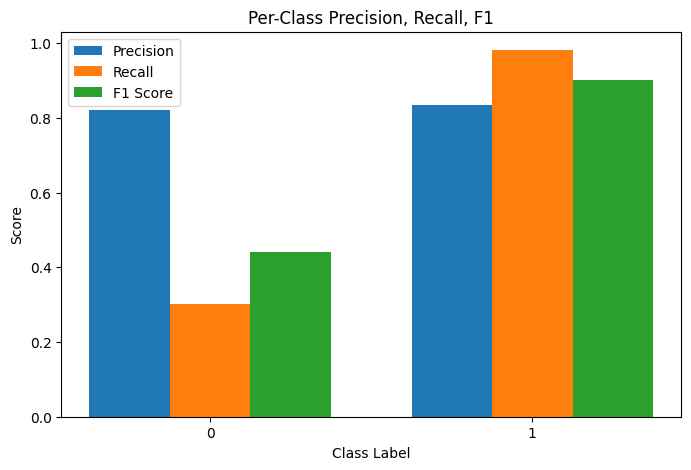

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
labels = list(range(len(prec)))

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xlabel("Class Label")
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, F1")
plt.xticks(x, labels)
plt.legend()
plt.show()


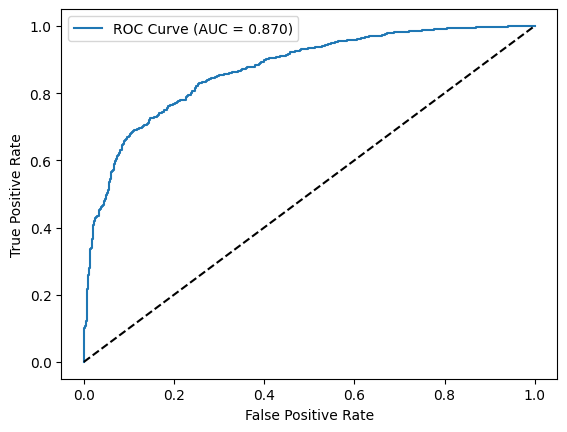

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.special import softmax
import matplotlib.pyplot as plt

probs = softmax(logits, axis=1)[:, 1]
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


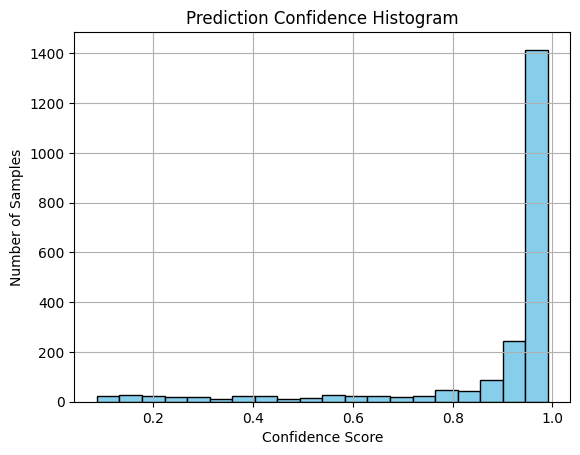

In [ ]:
confidence = np.array(probs)
if confidence.ndim > 1:
    confidence = np.max(confidence, axis=1)

plt.hist(confidence, bins=20, color='skyblue', edgecolor='black')
plt.title("Prediction Confidence Histogram")
plt.xlabel("Confidence Score")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


In [ ]:
drug = input("Enter the drug name: ")
user_input = input("Enter a drug review: ")
sentiment = predict_sentiment(user_input, drug)
print(f"Predicted Sentiment: {sentiment}")


Enter the drug name: Paracetamol
Enter a drug review: i took paracetamol when i had a high fever and body aches within a few hours my temperature went down and i felt much better didnt notice any side effects so far it really helped me recover quickly
Predicted Sentiment: Good


In [ ]:
drug = input("Enter the drug name: ")
user_input = input("Enter a drug review: ")
sentiment = predict_sentiment(user_input, drug)
print(f"Predicted Sentiment: {sentiment}")

Enter the drug name: Dicyclomine
Enter a drug review: I was prescribed Dicyclomine for stomach cramps. It eased the pain at first, but after a while, I started feeling dizzy and nauseous. I had to stop taking it because the side effects were too strong
Predicted Sentiment: Bad
